<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/04_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Transformer

We’re actually quite close to developing our own version of the famous
Transformer model. The encoder-decoder architecture with positional encoding
is missing only a few details to effectively "transform and roll out" :-)

First, we need to revisit the multi-headed attention mechanism to make it less
computationally expensive by using narrow attention. Then, we’ll learn about a
new kind of normalization: layer normalization.

Finally, we’ll add some more bells
and whistles: dropout, residual connections, and more "layers".

##Setup

In [1]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_chapter10()
# This is needed to render the plots in this chapter
from plots.chapter8 import *
from plots.chapter9 import *
from plots.chapter10 import *

Finished!


In [2]:
import copy
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision.transforms import Compose, Normalize, Pad

from data_generation.square_sequences import generate_sequences
from data_generation.image_classification import generate_dataset
from helpers import index_splitter, make_balanced_sampler
from stepbystep.v4 import StepByStep
# These are the classes we built in Chapter 9
from seq2seq import PositionalEncoding, subsequent_mask, EncoderDecoderSelfAttn

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

##Narrow Attention

We used full attention heads to build a multi-headed attention
and we called it wide attention. Although this mechanism works well, it gets
prohibitively expensive as the number of dimensions grows.

That’s when the narrow attention comes in: Each attention head will get a chunk of the
transformed data points (projections) to work with.

###Chunking

The attention heads do not
use chunks of the original data points, but rather those of their
projections.

Why?

To understand why, let’s take an example of an affine transformation, one that
generates "values" ($v_0$) from the first data point ($x_0$).

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/attn_narrow_transf.png?raw=1)

The transformation above takes a single data point of four dimensions (features) and turns it into a "value" (also with four dimensions) that’s going to be used in the attention mechanism.

At first sight, it may look like we’ll get the same result whether we split the inputs
into chunks or we split the projections into chunks. But that’s definitely not the case.
So, let’s zoom in and look at the individual weights inside that transformation.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/multihead_chunking.png?raw=1)

On the left, the correct approach: It computes the projections first and chunks them later. It is clear that each value in the projection (from $v_{00}$ to $v_{03}$) is a linear combination of all features in the data point.

Since each head is working with a subset of the projected
dimensions, these projected dimensions may end up
representing different aspects of the underlying data. For
natural language processing tasks, for example, some attention
heads may correspond to linguistic notions of syntax and
coherence. A particular head may attend to the direct objects of
verbs, while another head may attend to objects of prepositions,
and so on.

Now, compare it to the wrong approach, on the right: By chunking it first, each value in the projection is a linear combination of a subset of the features only.

Why is it so bad?

First, it is a simpler model (the wrong approach has only eight weights while the correct one has sixteen), so its learning capacity is limited. Second, since each head can only look at a subset of the features, they simply cannot learn about longrange dependencies in the inputs.

Now, let’s use a source sequence of length two as input, with each data point
having four features like the chunking example above, to illustrate our new self-attention mechanism.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/narrow-attention1.png?raw=1)

The flow of information goes like this:

* Both data points (x0 and x1) go through distinct affine transformations to generate the corresponding "values" (v0 and v1) and "keys" (k0 and k1), which we’ll be calling projections.

* Both data points also go through another affine transformation to generate the corresponding "queries" (q0 and q1).

* Each projection has the same number of dimensions as the inputs (four).

* Instead of simply using the projections, as former attention heads did, this attention head uses only a chunk of the projections to compute the context vector.

* Since projections have four dimensions, let’s split them into two chunks—blue (left) and green (right)—of two dimensions each.

* The first attention head uses only blue chunks to compute its context vector, which, like the projections, has only two dimensions.

* The second attention head (not depicted in the figure above) uses the green chunks to compute the other half of the context vector, which, in the end, has the desired dimension.

* Like the former multi-headed attention mechanism, the context vector goes through a feed-forward network to generate the "hidden states" (only the first one is depicted in the figure above).



###Multi-Headed Attention

The new multi-headed attention class is more than a combination of both the
Attention and MultiHeadedAttention classes: It implements the chunking of the projections and introduces dropout for attention scores.

In [4]:
class MultiHeadAttention(nn.Module):

  def __init__(self, n_heads, d_model, dropout=0.1):
    super(MultiHeadAttention, self).__init__()

    self.n_heads = n_heads
    self.d_model = d_model
    self.d_k = int(d_model / n_heads)

    # Affine transformations for Q, K, and V
    self.QUERY = nn.Linear(d_model, d_model)
    self.KEY = nn.Linear(d_model, d_model)
    self.VALUE = nn.Linear(d_model, d_model)

    self.linear_layer = nn.Linear(d_model, d_model)
    self.dropout = nn.Dropout(p=dropout)
    self.alphas = None

  def make_chunks(self, x):
    batch_size, seq_len = x.size(0), x.size(1)
    # N, L, D -> N, L, n_heads * d_k
    x = x.view(batch_size, seq_len, self.n_heads, self.d_k) # splits its last dimension in two
    # N, n_heads, L, d_k
    x = x.transpose(1, 2)
    return x

  def init_keys(self, key):
    # N, n_heads, L, d_k
    # Chunking the key, and value projections
    self.projection_key = self.make_chunks(self.KEY(key))
    self.projection_value = self.make_chunks(self.VALUE(key))

  def score_function(self, query):
    # scaled dot product
    # N, n_heads, L, d_k x # N, n_heads, d_k, L -> N, n_heads, L, L
    # Chunking the query projections
    projection_query = self.make_chunks(self.QUERY(query))
    dot_products = torch.matmul(projection_query, self.projection_key.transpose(-2, -1))
    scores = dot_products / np.sqrt(self.d_k)
    return scores

  def attention(self, query, mask=None):
    # Query is batch-first: N, L, D
    # Score function will generate scores for each head
    scores = self.score_function(query)  # N, n_heads, L, L
    if mask is not None:
      scores = scores.masked_fill(mask==0, -1e9)
    alphas = F.softmax(scores, dim=-1)  # N, n_heads, L, L
    alphas = self.dropout(alphas)
    self.alphas = alphas.detach()

    # N, n_heads, L, L x N, n_heads, L, d_k -> N, n_heads, L, d_k
    context = torch.matmul(alphas, self.projection_value)
    return context

  def output_function(self, contexts):
    # N, L, D
    output = self.linear_layer(contexts)  # N, L, D
    return output

  def forward(self, query, mask=None):
    if mask is not None:
      # N, 1, L, L - every head uses the same mask
      mask = mask.unsqueeze(1)

    # N, n_heads, L, d_k
    contexts = self.attention(query, mask=mask)
    # Concatenating the context vectors
    # N, L, n_heads, d_k
    contexts = contexts.transpose(1, 2).contiguous()
    # N, L, n_heads * d_k = N, L, d_model
    contexts = contexts.view(query.size(0), -1, self.d_model)
    # N, L, d_model
    output = self.output_function(contexts)
    return output

We can generate some dummy points corresponding to a mini-batch of 16
sequences (N), each sequence having two data points (L), each data point having
four features (F):

In [5]:
dummy_points = torch.randn(16, 2, 4) # N, L, F
multi_head_attention = MultiHeadAttention(n_heads=2, d_model=4, dropout=0.0)
multi_head_attention.init_keys(dummy_points)
output = multi_head_attention(dummy_points) # N, L, D
output.shape

torch.Size([16, 2, 4])

Since we’re using the data points as "keys," "values," and "queries," this is a selfattention mechanism.

The figure below depicts a multi-headed attention mechanism with its two heads,
blue (left) and green (right), and the first data point being used as a "query" to
generate the first "hidden state" ($h_0$).

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/narrow-attention2.png?raw=1)


The important thing to remember here is: "**Multi-headed attention chunks the projections, not the inputs.**"

###Stacking Encoders and Decoders

Let’s make our encoder-decoder architecture deeper by stacking two encoders on
top of one another, and then do the same with two decoders.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/stacking-encoders-decoders1.png?raw=1)

The output of one encoder feeds the cross-attention mechanism of all stacked
decoders. The output of one decoder feeds the next, and the last decoder outputs predictions as usual.

The figure above represents an encoder-decoder architecture with two "layers"
each. But we’re not stopping there: We’re stacking six "layers"!

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/stacking-encoders-decoders2.png?raw=1)

By the way, that’s exactly how a Transformer is built!

Cool! Is this a Transformer already then?

Not yet, no. We need to work further on the "sub-layers" to transform the architecture above into a real Transformer.

###Wrapping "Sub-Layers"

As our model grows deeper, with many stacked "layers," we’re going to run into
familiar issues, like the vanishing gradients problem. In computer vision models, this issue was successfully addressed by the addition of other components, like batch normalization and residual connections.

But we also know that dropout works pretty well as a regularizer, so we can throw
that in the mix as well.

We’ll wrap each and every "sub-layer" with them! Cool, right? But that brings up another question: How to wrap them?

It turns out, we can wrap a "sub-layer" in one of two ways: norm-last or norm-first.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/stacking-encoders-decoders3.png?raw=1)

Let’s turn the diagrams above into equations:

$$
\Large
\begin{aligned}
&\text{outputs}_{\text{norm-last}}=&\text{norm(inputs + dropout(sublayer(inputs))}
\\
&\text{outputs}_{\text{norm-first}}=&\text{inputs + dropout(sublayer(norm(inputs)))}
\end{aligned}
$$

The equations are almost the same, except for the fact that the norm-last wrapper normalizes the outputs and the norm-first wrapper normalizes the inputs. That’s a small, yet important, difference.

Why?

If you’re using positional encoding, you want to normalize your inputs, so norm-first is more convenient.

We’ll normalize the final outputs; that is, the output of the last "layer".

From now on, we’re sticking with norm-first, thus normalizing the inputs:


$$
\Large
\begin{aligned}
&\text{outputs}_{\text{norm-first}}=&\text{inputs + dropout(sublayer(norm(inputs)))}
\end{aligned}
$$

By wrapping each and every "sub-layer" inside both encoder "layers" and decoder "layers," we’ll arrive at the desired Transformer architecture.


###Transformer Encoder

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/stacking-encoders-decoders4.png?raw=1)

On the left, the encoder uses a norm-last wrapper, and its output (the encoder’s states) is given by:

$$
\large
\begin{aligned}
&\text{outputs}_{\text{norm-last}}=&\text{norm}(\underbrace{\text{norm(inputs + att(inputs))}}_{\text{Output of SubLayer}_0} + \text{ffn}(\underbrace{\text{norm(inputs + att(inputs))}}_{\text{Output of SubLayer}_0}))
\end{aligned}
$$

On the right, the encoder uses a norm-first wrapper, and its output (the encoder’s states) is given by:

$$
\large
\begin{aligned}
&\text{outputs}_{\text{norm-first}}=&\underbrace{\text{inputs + att(norm(inputs))}}_{\text{Output of SubLayer}_0}+\text{ffn(norm(}\underbrace{\text{inputs + att(norm(inputs))}}_{\text{Output of SubLayer}_0}))
\end{aligned}
$$

The norm-first wrapper allows the inputs to flow unimpeded (the inputs aren’t
normalized) all the way to the top while adding the results of each "sub-layer" along
the way.

Which one is best?

There is no straight answer to this question. It actually  placing the batch normalization layer before or after the
activation function.

Let’s see it in code, starting with the "layer," and all its wrapped "sub-layers":

In [6]:
class EncoderLayer(nn.Module):

  def __init__(self, n_heads, d_model, ff_units, dropout=0.1):
    super().__init__()

    self.n_heads = n_heads
    self.d_model = d_model
    self.ff_units = ff_units
    self.dropout = dropout

    self.self_attention_heads = MultiHeadAttention(n_heads, d_model, dropout)
    self.feed_forward_network = nn.Sequential(
        nn.Linear(d_model, ff_units),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(ff_units, d_model)
    )

    # define layer normalization
    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.dropout1 = nn.Dropout(dropout)
    self.dropout2 = nn.Dropout(dropout)

  def forward(self, query, mask=None):
    # Sublayer #0
    # Norm
    norm_query = self.norm1(query)
    # Multi-headed Attention
    self.self_attention_heads.init_keys(norm_query)
    states = self.self_attention_heads(norm_query, mask)
    # Add
    attention = query + self.dropout1(states)

    # Sublayer #1
    # Norm
    norm_attention = self.norm2(attention)
    # Feed Forward
    output = self.feed_forward_network(norm_attention)
    # Add
    output = attention + self.dropout2(output)
    return output

Now we can stack a bunch of "layers" like that to build an actual encoder.Its constructor takes an instance of an EncoderLayer, the number
of "layers" we’d like to stack on top of one another, and a max length of the source
sequence that’s going to be used for the positional encoding.

The final outputs are, as usual, the states of the
encoder that will feed the cross-attention mechanism of every "layer" of the
decoder.

In [7]:
class TransformerEncoder(nn.Module):

  def __init__(self, encoder_layer, n_layers=1, max_len=100):
    super().__init__()

    self.d_model = encoder_layer.d_model
    self.positional_encoding = PositionalEncoding(max_len, self.d_model)
    self.norm_layer = nn.LayerNorm(self.d_model)
    self.layers = nn.ModuleList([copy.deepcopy(encoder_layer) for _ in range(n_layers)])

  def forward(self, query, mask=None):
    # Positional Encoding
    x = self.positional_encoding(query)
    for layer in self.layers:
      x = layer(x, mask)
    # Norm
    return self.norm_layer(x)

###Transformer Decoder

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/stacking-encoders-decoders5.png?raw=1)

The small arrow on the left represents the states produced by the encoder, which will be used as inputs for "keys" and "values" of the (cross-)multi-headed attention mechanism in each "layer."

Moreover, there is one final linear layer responsible for projecting the decoder’s output back to the original number of dimensions.

Let’s see it in code, starting with the "layer" and all its wrapped "sub-layers."

In [8]:
class DecoderLayer(nn.Module):

  def __init__(self, n_heads, d_model, ff_units, dropout=0.1):
    super().__init__()

    self.n_heads = n_heads
    self.d_model = d_model
    self.ff_units = ff_units
    self.dropout = dropout

    self.self_attention_heads = MultiHeadAttention(n_heads, d_model, dropout=dropout)
    self.cross_attention_heads = MultiHeadAttention(n_heads, d_model, dropout=dropout)
    self.feed_forward_network = nn.Sequential(
        nn.Linear(d_model, ff_units),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(ff_units, d_model)
    )

    # define layer normalization
    self.norm1 = nn.LayerNorm(d_model)
    self.norm2 = nn.LayerNorm(d_model)
    self.norm3 = nn.LayerNorm(d_model)
    self.dropout1 = nn.Dropout(dropout)
    self.dropout2 = nn.Dropout(dropout)
    self.dropout3 = nn.Dropout(dropout)

  def init_keys(self, states):
    self.cross_attention_heads.init_keys(states)

  def forward(self, query, source_mask=None, target_mask=None):
    # Sublayer #0
    # Norm
    norm_query = self.norm1(query)
    # Masked Multi-head Attention
    self.self_attention_heads.init_keys(norm_query)
    # target mask used to avoid cheating by peeking into the future.
    states = self.self_attention_heads(norm_query, target_mask)
    # Add
    attention1 = query + self.dropout1(states)

    # Sublayer #1
    # Norm
    norm_attention1 = self.norm2(attention1)
    # Cross Multi-head Attention
    # ignore padded data points in the source sequence during cross-attention
    encoder_states = self.cross_attention_heads(norm_attention1, source_mask)
    # Add
    attention2 = attention1 + self.dropout2(encoder_states)

    # Sublayer #2
    # Norm
    norm_attention2 = self.norm3(attention2)
    # Feed Forward
    output = self.feed_forward_network(norm_attention2)
    # Add
    output = attention2 + self.dropout3(output)
    return output

Now we can stack a bunch of "layers" like that to build an actual decoder.

In [9]:
class TransformerDecoder(nn.Module):

  def __init__(self, decoder_layer, n_layers=1, max_len=100):
    super(TransformerDecoder, self).__init__()

    self.d_model = decoder_layer.d_model
    self.positional_encoding = PositionalEncoding(max_len, self.d_model)
    self.norm_layer = nn.LayerNorm(self.d_model)
    self.layers = nn.ModuleList([copy.deepcopy(decoder_layer) for _ in range(n_layers)])

  def init_keys(self, states):
    for layer in self.layers:
      layer.init_keys(states)

  def forward(self, query, source_mask=None, target_mask=None):
    # Positional Encoding
    x = self.positional_encoding(query)
    for layer in self.layers:
      x = layer(x, source_mask, target_mask)
    # Norm
    return self.norm_layer(x)

##Layer Normalization

Layer normalization standardizes individual data points, not features.

This is completely different than the standardizations because each feature, either in the whole training set or in a mini-batch was standardized to have zero mean and unit standard deviation.

In a tabular dataset, we standardized the columns.

Layer normalization, in a tabular dataset, standardizes the rows.
Each data point will have the average of its features equal zero,
and the standard deviation of its features will equal one.

Let’s assume we have a mini-batch of three sequences (N=3), each sequence having
a length of two (L=2), each data point having four features (D=4).

In [10]:
torch.manual_seed(34)

d_model = 4
seq_len = 2
n_points = 3

data = torch.randn(n_points, seq_len, d_model)
data

tensor([[[-1.9024,  0.4950, -0.8662,  0.5679],
         [ 0.4720,  0.1376,  0.0508, -1.3710]],

        [[-1.2136,  0.1780,  1.4307,  0.5042],
         [-0.9384, -0.9085, -1.1091, -0.8476]],

        [[-0.4022,  0.4854,  1.6852,  0.5294],
         [ 1.6921,  3.2086,  0.7335,  0.5381]]])

In [11]:
pe = PositionalEncoding(seq_len, d_model)
inputs = pe(data)
inputs

tensor([[[-3.8049,  1.9899, -1.7325,  2.1359],
         [ 1.7854,  0.8155,  0.1116, -1.7420]],

        [[-2.4273,  1.3559,  2.8615,  2.0084],
         [-1.0353, -1.2766, -2.2082, -0.6952]],

        [[-0.8044,  1.9707,  3.3704,  2.0587],
         [ 4.2256,  6.9575,  1.4770,  2.0762]]])

It should be straightforward to identify the different dimensions, N (three vertical groups), L (two rows in each group), and D (four columns), in the tensor above.

There are six data points in total, and their value range is mostly the result of the addition of positional encoding.

Well, layer normalization standardizes individual data points, the rows in the
tensor above, so we need to compute statistics over the corresponding dimension(D).

Let’s start with the means:

$$
\Large
\overline{X}_{n,l} = \frac{1}{D}\sum_{d=1}^Dx_{n,l,d}
$$

In [12]:
inputs_mean = inputs.mean(axis=2).unsqueeze(2)
inputs_mean

tensor([[[-0.3529],
         [ 0.2426]],

        [[ 0.9496],
         [-1.3038]],

        [[ 1.6489],
         [ 3.6841]]])

As expected, six mean values, one for each data point. The `unsqueeze()` is there to preserve the original dimensionality, thus making the result a tensor of `(N, L, 1)` shape.

Next, we compute the biased standard deviations over the same dimension (D):

$$
\Large
\sigma_{n,l}(X) = \sqrt{\frac{1}{D}\sum_{d=1}^D(x_{n,l,d}-\overline{X}_{n,l})^2}
$$

In [13]:
inputs_var = inputs.var(axis=2, unbiased=False).unsqueeze(2)
inputs_var

tensor([[[6.3756],
         [1.6661]],

        [[4.0862],
         [0.3153]],

        [[2.3135],
         [4.6163]]])

The actual standardization is then computed using the mean, biased standard
deviation, and a tiny epsilon to guarantee numerical stability:

$$
\Large
\text{standardized}\ x_{n,l,d}=\frac{x_{n,l,d}-\overline{X}_{n,l}}{\sigma_{n,l}(X) + \epsilon}
$$

In [14]:
(inputs - inputs_mean) / torch.sqrt(inputs_var + 1e-5)

tensor([[[-1.3671,  0.9279, -0.5464,  0.9857],
         [ 1.1953,  0.4438, -0.1015, -1.5376]],

        [[-1.6706,  0.2010,  0.9458,  0.5238],
         [ 0.4782,  0.0485, -1.6106,  1.0839]],

        [[-1.6129,  0.2116,  1.1318,  0.2695],
         [ 0.2520,  1.5236, -1.0272, -0.7484]]])

The values above are layer normalized. It is possible to achieve the very same
results by using PyTorch’s own `nn.LayerNorm`, of course:

In [15]:
layer_norm = nn.LayerNorm(d_model)
normalized = layer_norm(inputs)
normalized

tensor([[[-1.3671,  0.9279, -0.5464,  0.9857],
         [ 1.1953,  0.4438, -0.1015, -1.5376]],

        [[-1.6706,  0.2010,  0.9458,  0.5238],
         [ 0.4782,  0.0485, -1.6106,  1.0839]],

        [[-1.6129,  0.2116,  1.1318,  0.2695],
         [ 0.2520,  1.5236, -1.0272, -0.7484]]],
       grad_fn=<NativeLayerNormBackward0>)

In [16]:
normalized[0][0].mean(), normalized[0][0].std(unbiased=False)

(tensor(-1.4901e-08, grad_fn=<MeanBackward0>),
 tensor(1.0000, grad_fn=<StdBackward0>))

Why do they have a grad_fn attribute?

Like batch normalization, layer normalization can learn affine transformations. Yes.

Each feature has its own affine transformation. Since we’re using layer
normalization on d_model, and its dimensionality is four, there will be four weights and four biases in the `state_dict()`:

In [17]:
layer_norm.state_dict()

OrderedDict([('weight', tensor([1., 1., 1., 1.])),
             ('bias', tensor([0., 0., 0., 0.]))])

The weights and biases are used to scale and translate, respectively, the
standardized values:

$$
\Large
\text{layer normed}\ x_{n,l,d} = b_d + w_d\ \text{standardized}\ x_{n,l,d}
$$

In PyTorch’s documentation, though, you’ll find gamma and beta instead:

$$
\Large
\text{layer normed}\ x_{n,l,d} = \text{standardized}\ x_{n,l,d}\ \gamma_d + \beta_d
$$

Batch and layer normalization look quite similar to one another, but there are some
important differences between them that we need to point out.

###Batch vs Layer

Although both normalizations compute statistics, namely, mean and biased
standard deviation, to standardize the inputs, only batch norm needs to keep track of running statistics.

Moreover, since layer normalization considers data points
individually, it exhibits the same behavior whether the model is
in training or in evaluation mode.

To illustrate the difference between the two types of normalization, let’s generate
yet another dummy example.

In [18]:
torch.manual_seed(23)

dummy_points = torch.randn(4, 1, 256)
dummy_pe = PositionalEncoding(1, 256)
dummy_encoder = dummy_pe(dummy_points)
dummy_encoder

tensor([[[-14.4193,  10.0495,  -7.8116,  ..., -15.4844, -18.0732,  -3.9566]],

        [[  2.6628,  -3.5462, -23.6461,  ...,  -0.9403, -18.4375, -37.4197]],

        [[-24.6397,  -1.9127, -16.4244,  ..., -17.3708, -26.0550, -14.0706]],

        [[ 13.7988,  21.4612,  10.4125,  ...,  -3.2333, -17.0188,   3.9237]]])

There are four sequences, so let’s pretend there are two mini-batches of two
sequences each (N=2). Each sequence has a length of one (L=1 is not quite a
sequence, I know), and their sole data points have 256 features (D=256).

The figure below illustrates the difference between applying batch norm (over features/columns) and layer norm (over data points/rows).

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/stacking-encoders-decoders6.png?raw=1)

As we learned that the size of the mini-batch strongly impacts the
running statistics of the batch normalization. We also learned that batch norm’s oscillating statistics may introduce a regularizing effect.

None of this happens with layer normalization: It steadily delivers data points with zero mean and unit standard deviation regardless of our choice of mini-batch size or anything else.

First, we’re visualizing the distribution of the positionally-encoded features that we generated.

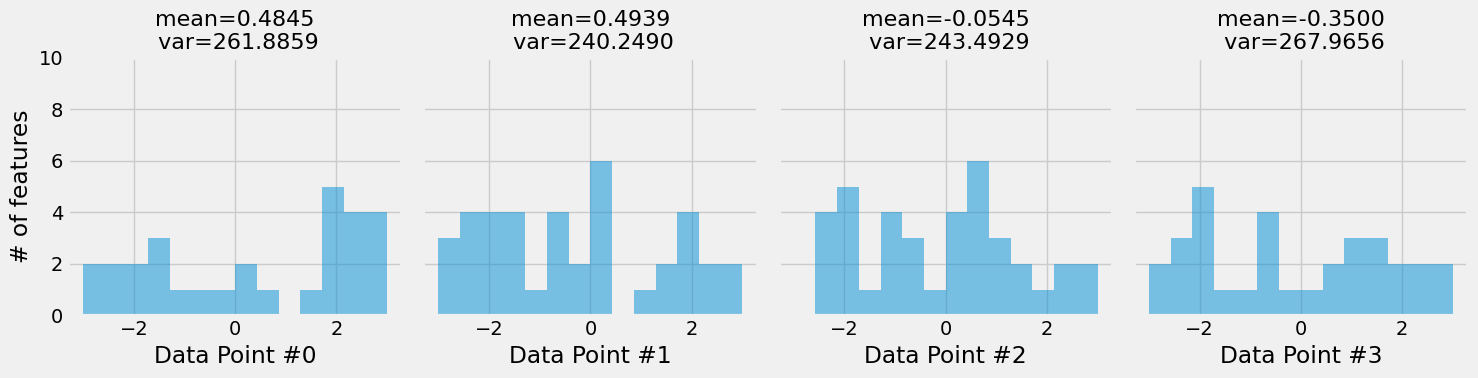

In [19]:
fig = hist_encoding(dummy_encoder)

The actual range is much larger than that (like -50 to 50), and the variance is approximately the same as the dimensionality (256) as a result of the addition of positional encoding.

Let’s apply layer normalization to it:

In [20]:
layer_normalizer = nn.LayerNorm(256)
dummy_normed = layer_normalizer(dummy_encoder)
dummy_normed

tensor([[[-0.9210,  0.5911, -0.5127,  ..., -0.9868, -1.1467, -0.2744]],

        [[ 0.1399, -0.2607, -1.5574,  ..., -0.0925, -1.2214, -2.4460]],

        [[-1.5755, -0.1191, -1.0491,  ..., -1.1097, -1.6662, -0.8982]],

        [[ 0.8643,  1.3324,  0.6575,  ..., -0.1761, -1.0183,  0.2611]]],
       grad_fn=<NativeLayerNormBackward0>)

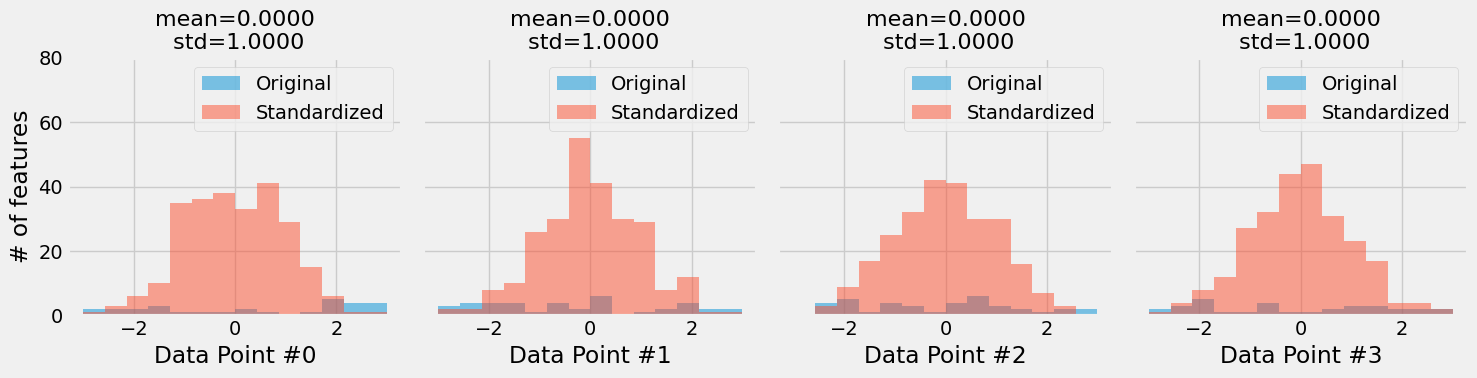

In [21]:
fig = hist_layer_normed(dummy_encoder, dummy_normed)

Each data point has its feature values distributed with zero mean and unit
standard deviation. Beautiful!

###Seq2Seq Problem

Let’s go back to our sequence-to-sequence problem, where the source
sequence had two data points, each data point representing the coordinates of
two corners.

As usual, we’re adding positional encoding to it:

In [22]:
pe = PositionalEncoding(max_len=2, d_model=2)

source_seq = torch.tensor([
    [
        [1.0349, 0.9661],
        [0.8055, -0.9169]
    ]
])

source_seq_encoder = pe(source_seq)
source_seq_encoder

tensor([[[ 1.4636,  2.3663],
         [ 1.9806, -0.7564]]])

Next, we normalize it.

In [23]:
norm = nn.LayerNorm(2)
norm(source_seq_encoder)

tensor([[[-1.0000,  1.0000],
         [ 1.0000, -1.0000]]], grad_fn=<NativeLayerNormBackward0>)

Wait, what happened here?

That’s what happens when one tries to normalize two features only: They become
either minus one or one.

Even worse, it will be the same for every data point. These
values won’t get us anywhere, that’s for sure.

We need to do better, we need…

###Projections or Embeddings

Sometimes projections and embeddings are used
interchangeably. Here, though, we’re sticking with embeddings
for categorical values and projections for numerical values.

We use embeddings to get a numerical representation (a vector) for a given word or token. Since words or tokens are categorical values,
the embedding layer works like a large lookup table: It will look up a given word or token in its keys and return the corresponding tensor.

But, since we’re dealing with coordinates, that is, numerical values, we are using projections instead.

A simple linear layer is all that it takes to project our pair of coordinates into a higherdimensional feature space:

In [24]:
torch.manual_seed(11)

projection_dim = 6
linear_projection = nn.Linear(2, projection_dim)
pe = PositionalEncoding(2, projection_dim)
source_seq_projection = linear_projection(source_seq)
source_seq_projection_encoder = pe(source_seq_projection)
source_seq_projection_encoder

tensor([[[-2.0934,  1.5040,  1.8742,  0.0628,  0.3034,  2.0190],
         [-0.8853,  2.8213,  0.5911,  2.4193, -2.5230,  0.3599]]],
       grad_fn=<AddBackward0>)

Now each data point in our source sequence has six features (the projected
dimensions), and they are positionally-encoded too.

Sure, this particular projection is totally random, but that won’t be the case once we add the corresponding linear
layer to our model.

It will learn a meaningful projection that, after being
positionally-encoded, will be normalized:

In [25]:
norm = nn.LayerNorm(projection_dim)
norm(source_seq_projection_encoder)

tensor([[[-1.9061,  0.6287,  0.8896, -0.3868, -0.2172,  0.9917],
         [-0.7362,  1.2864,  0.0694,  1.0670, -1.6299, -0.0568]]],
       grad_fn=<NativeLayerNormBackward0>)

Problem solved! Finally, we have everything we need to build a full-blown
Transformer!

In attention, we used affine transformations inside the attention
heads to map from input dimensions to hidden (or model)
dimensions.

Now, this change in dimensionality is being
performed using projections directly on the input sequences
before they are passed to the encoder and the decoder.

##Transformer

Let’s start with the diagram, which is nothing more than an encoder and a decoder side-by-side.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/transformer.png?raw=1)

The Transformer still is an encoder-decoder architecture, so it should be no surprise that we can actually
use our former `EncoderDecoderSelfAttention` class as a parent class and add two extra components to it:
- A projection layer to map our original features (`n_features`) to the
dimensionality of both encoder and decoder (`d_model`).
- A final linear layer to map the decoder’s outputs back to the original feature space (the coordinates we’re trying to predict).

We also need to make some small modifications to the `encode()` and `decode()`
methods to account for the components above:


In [30]:
class TransformerEncoderDecoder(EncoderDecoderSelfAttn):
  def __init__(self, encoder, decoder, input_len, target_len, n_features):
    super(TransformerEncoderDecoder, self).__init__(encoder, decoder, input_len, target_len)

    self.n_features = n_features
    # Projecting features to model dimensionality
    self.projection = nn.Linear(n_features, encoder.d_model)
    # Final linear transformation from model to feature space
    self.linear = nn.Linear(encoder.d_model, n_features)

  def encode(self, source_seq, source_mask=None):
    # Projection
    source_projection = self.projection(source_seq)
    encoder_states = self.encoder(source_projection, source_mask)
    self.decoder.init_keys(encoder_states)

  def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
    # Projection
    target_projection = self.projection(shifted_target_seq)
    outputs = self.decoder(target_projection, source_mask=source_mask, target_mask=target_mask)
    # Linear
    outputs = self.linear(outputs)
    return outputs

###Data Preparation

We’ll keep drawing the first two corners of the squares ourselves, the source
sequence, and ask our model to predict the next two corners, the target sequence.

In [ ]:
# Generating training data
points, directions = generate_sequences(n=256, seed=13)
full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]

# Generating test data
test_points, test_directions = generate_sequences(seed=17)
full_test = torch.as_tensor(test_points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]

# Datasets and data loaders
train_data = TensorDataset(full_train, target_train)
test_data = TensorDataset(source_test, target_test)
generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)
test_loader = DataLoader(test_data, batch_size=16)

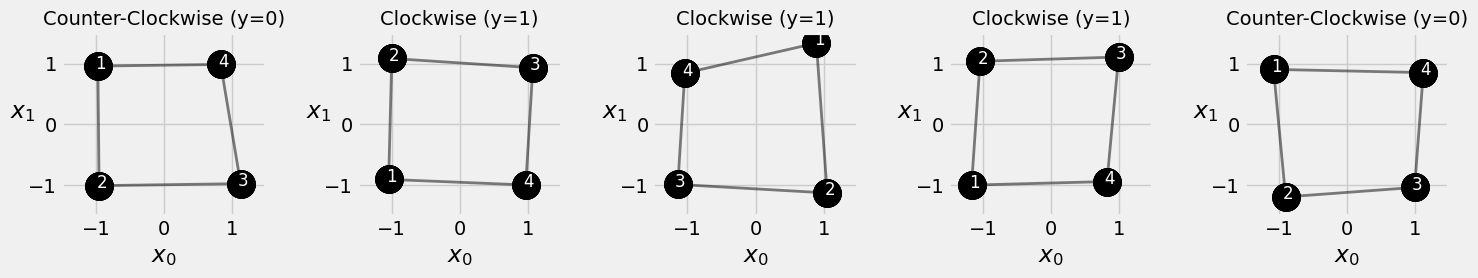

In [28]:
fig = plot_data(points, directions, n_rows=1)

###Model Training

Let’s train our Transformer!

We start by creating the corresponding "layers" for
both encoder and decoder, and use them both as arguments of the
`TransformerEncoderDecoder` class:

In [31]:
torch.manual_seed(42)

# Layers
encoder_layer = EncoderLayer(n_heads=3, d_model=6, ff_units=10, dropout=0.1)
decoder_layer = DecoderLayer(n_heads=3, d_model=6, ff_units=10, dropout=0.1)

# Encoder and Decoder
encoder_transformer = TransformerEncoder(encoder_layer, n_layers=2)
decoder_transformer = TransformerDecoder(decoder_layer, n_layers=2)

# Transformer
model_transformer = TransformerEncoderDecoder(encoder_transformer, decoder_transformer, input_len=2, target_len=2, n_features=2)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model_transformer.parameters(), lr=0.01)

In [32]:
for param in model_transformer.parameters():
  if param.dim() > 1:
    # The original Transformer model was initialized using Glorot / Xavier uniform distribution
    nn.init.xavier_uniform_(param)

In [33]:
sbs_seq_transformer = StepByStep(model_transformer, loss, optimizer)
sbs_seq_transformer.set_loaders(train_loader, test_loader)
sbs_seq_transformer.train(50)

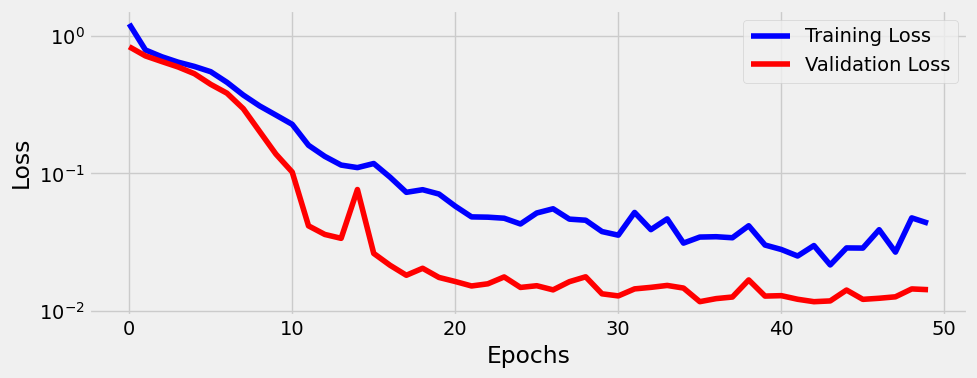

In [34]:
fig = sbs_seq_transformer.plot_losses()

In our Transformer model, there are many dropout layers,
so it gets increasingly more difficult for the model to learn.

Let’s observe this effect by using the same mini-batch to compute the loss using the trained model in both train and eval modes:

In [35]:
torch.manual_seed(11)

x, y = next(iter(train_loader))
device = sbs_seq_transformer.device

# Training
model_transformer.train()
loss(model_transformer(x.to(device)), y.to(device))

tensor(0.0185, grad_fn=<MseLossBackward0>)

In [36]:
# Validation
model_transformer.eval()
loss(model_transformer(x.to(device)), y.to(device))

tensor(0.0091)

See the difference? The loss is roughly two times larger in training mode.

Let’s plot the predicted coordinates.

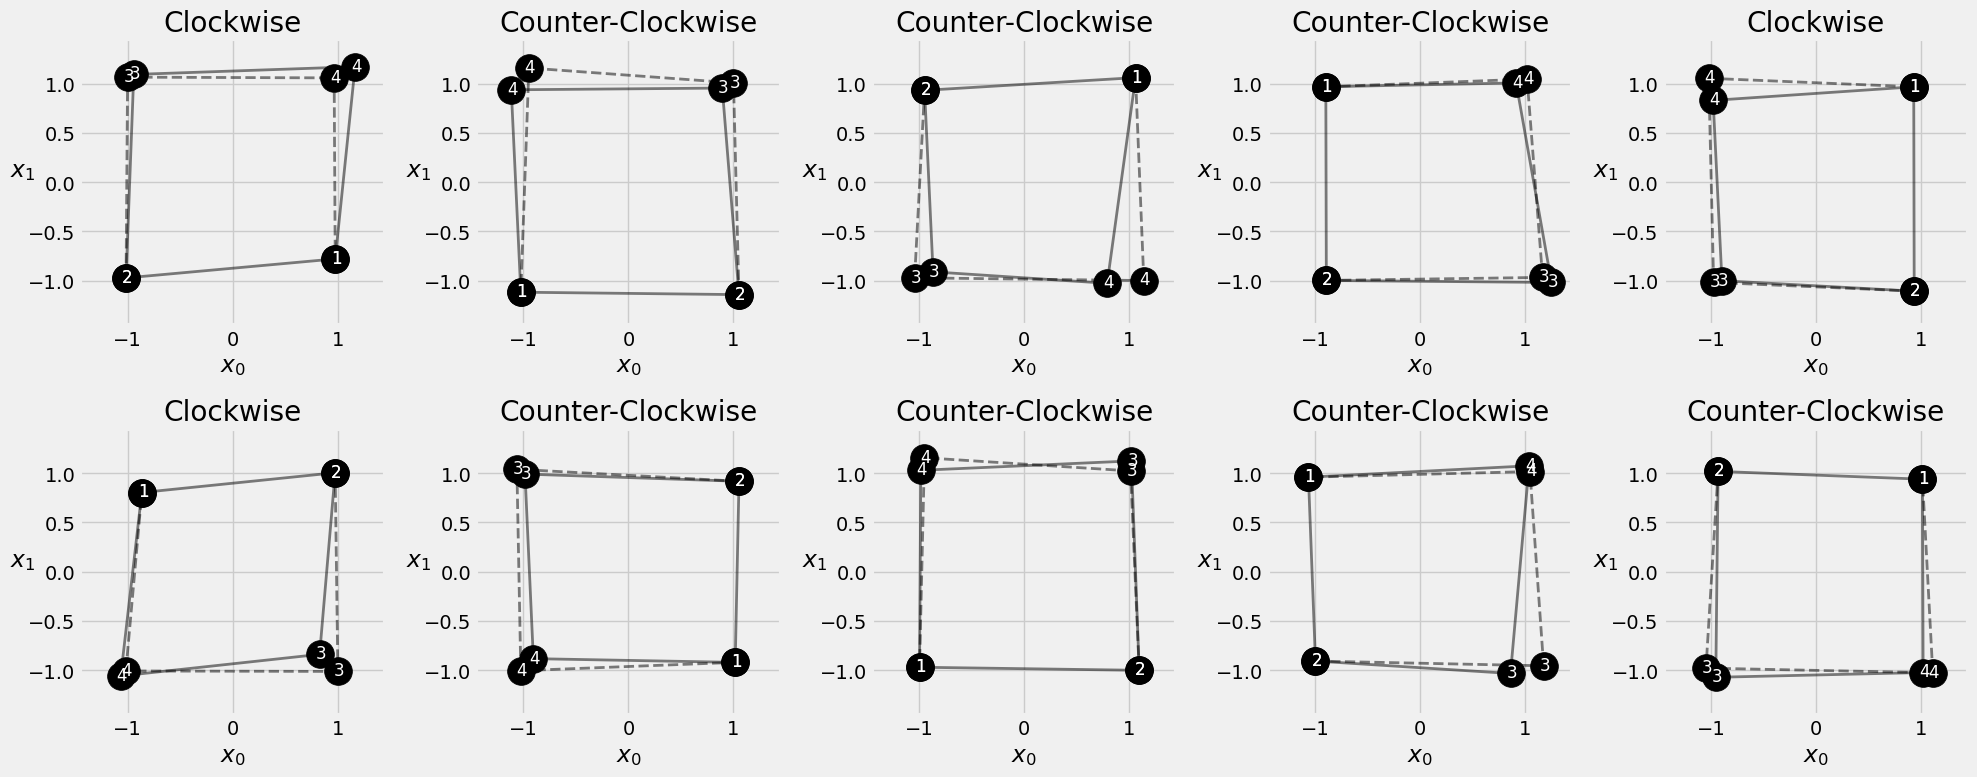

In [37]:
fig = sequence_pred(sbs_seq_transformer, full_test, test_directions)

##PyTorch Transformer